In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as pl
import xarray as xr
from scipy.integrate import odeint
import regionmask
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import scipy.stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table 
import time
import warnings
import seaborn as sns
from sklearn.metrics import r2_score#print(r2_score(y3,y3_fitted))

import xlrd
import random
####     ax.set_extent([-15, 45, 28, 76], crs=ccrs.PlateCarree())
from sklearn import preprocessing
robust = preprocessing.RobustScaler()
warnings.filterwarnings('ignore')
from matplotlib import cm
from matplotlib.colors import ListedColormap
from cartopy.util import add_cyclic_point

# Pre

# 空间GINI系数

In [2]:
cd //home/user/workdir/Pre

/home/user/workdir/Pre


In [3]:
pre_50_55=xr.open_dataset('era5_regrid_50-55.nc')
pre_56_85=xr.open_dataset('era5_regrid_56-85.nc')
pre_86_09=xr.open_dataset('era5_regrid_86-09.nc')
pre_10_20=xr.open_dataset('era5_regrid_10-20.nc')

In [4]:
data=xr.open_dataset('era5_regrid_50-55.nc')

In [5]:
pre_50_55_year=pre_50_55.groupby('time.year').mean('time')
pre_56_85_year=pre_56_85.groupby('time.year').mean('time')
pre_86_09_year=pre_86_09.groupby('time.year').mean('time')
pre_10_20_year=pre_10_20.groupby('time.year').mean('time')

In [6]:
pre_1_np=np.array(pre_50_55_year.tp)
pre_2_np=np.array(pre_56_85_year.tp)
pre_3_np=np.array(pre_86_09_year.tp)
pre_4_np=np.array(pre_10_20_year.tp)

In [7]:
pre_year_all=np.concatenate((pre_1_np,pre_2_np,pre_3_np,pre_4_np))##1950-2020

In [8]:
pre_year_all[pre_year_all<0.001]=0

In [9]:
pre_year_end=pre_year_all[1:,:,:]*1000*365#1970-2020

In [14]:
pre_year_end.shape

(70, 181, 360)

# 区域计算  

In [10]:
names=regionmask.defined_regions.ar6.land.names

In [11]:
lat= pre_50_55.latitude
lon=pre_50_55.longitude
mask = regionmask.defined_regions.ar6.land.mask(lon, lat)

In [12]:
mask_46=np.zeros((46,181,360))
for i in range(0,46):
    mask_temp=mask==i
    mask_46[i,:]=mask_temp+0
mask_46[mask_46==0]=np.nan

In [13]:
pre_year_region=np.zeros((46,70))
for i in range(0,46):
    print(i)
    pre_year_region[i,:]=np.nanmean(np.nanmean(pre_year_end[:,:,:]*mask_46[i,:],axis=1),axis=1)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


In [14]:
pre_year_region_mean=np.nanmean(pre_year_region[:,0:20],axis=1)

# 空间GINI系数

In [15]:
def gini(wealths):
    cum_wealths = np.cumsum(sorted(np.append(wealths, 0)))
    sum_wealths = cum_wealths[-1]
    xarray = np.array(range(0, len(cum_wealths))) / np.float(len(cum_wealths) - 1)
    upper = xarray
    yarray = cum_wealths / sum_wealths
#     pl.plot(xarray, yarray)
#     pl.plot(xarray, upper)
    B = np.trapz(yarray, x=xarray)
    A = 0.5 - B
    G = A / (A + B)
    return(G)
#     print (G)

In [16]:
index_nan=np.zeros((46,1))
for mask_index in range(0,46):
    data_region=np.array(pd.DataFrame(np.array(pre_year_end[1,:,:]*mask_46[mask_index,:,:])).fillna(9999))
    data_flatten =data_region.flatten(('c'))
    data_flatten.sort()
    index=np.sum(data_flatten == 9999)
    index_nan[mask_index]=index
index_region=65160-index_nan

In [17]:
gini_space=np.zeros((46,70))
for region in range(0,46):
    for year in range(0,70):
        data_temp=np.array(pd.DataFrame(pre_year_end[year,:,:]*mask_46[region,:,:]).fillna(9999))
        data_flatten=data_temp.flatten(('c'))
        data_flatten.sort()
        data_list=data_flatten[0:int(index_region[region])]
        gini_this=gini(data_list)
        gini_space[region,year]=gini_this

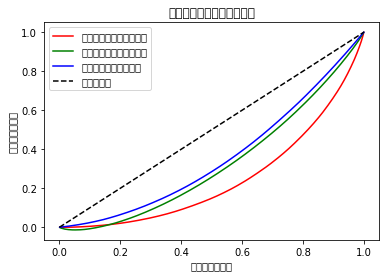

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 函数：计算洛伦兹曲线
def calculate_lorenz_curve(data):
    data_sorted = np.sort(data)
    cumulative_percentage = np.arange(1, len(data) + 1) / len(data)
    lorenz_curve_y = np.cumsum(data_sorted) / np.sum(data_sorted)
    return cumulative_percentage, lorenz_curve_y

# 生成三组数据
# 数据集1：高度不平等，使用指数分布
data1 = np.random.exponential(scale=1000, size=1000)

# 数据集2：中等不平等，使用正态分布
data2 = np.random.normal(loc=500, scale=300, size=1000)

# 数据集3：接近平等，使用均匀分布
data3 = np.random.uniform(low=100, high=1100, size=1000)

# 计算每组数据的洛伦兹曲线
cumulative_percentage, lorenz_curve_y1 = calculate_lorenz_curve(data1)
_, lorenz_curve_y2 = calculate_lorenz_curve(data2)
_, lorenz_curve_y3 = calculate_lorenz_curve(data3)

# 绘制洛伦兹曲线
plt.plot(cumulative_percentage, lorenz_curve_y1, 'r-', label='高度不平等（指数分布）')
plt.plot(cumulative_percentage, lorenz_curve_y2, 'g-', label='中等不平等（正态分布）')
plt.plot(cumulative_percentage, lorenz_curve_y3, 'b-', label='接近平等（均匀分布）')

# 绘制完全平等线（45度线）
plt.plot([0, 1], [0, 1], 'k--', label='完全平等线')

# 设置图表标题和标签
plt.title('三条差异明显的洛伦兹曲线')
plt.xlabel('累积人口百分比')
plt.ylabel('累积财富百分比')
plt.legend()

# 显示图表

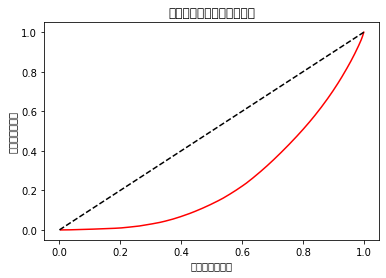

In [19]:
def calculate_lorenz_curve(data):
    data_sorted = np.sort(data)
    cumulative_percentage = np.arange(1, len(data) + 1) / len(data)
    lorenz_curve_y = np.cumsum(data_sorted) / np.sum(data_sorted)
    return cumulative_percentage, lorenz_curve_y

for region in range(23,24):
    cumulative_percentage_cum=np.zeros((20,236))
    lorenz_curve_y1_cum=np.zeros((20,236))
    for year in range(0,20):
        data_temp=np.array(pd.DataFrame(pre_year_end[year,:,:]*mask_46[region,:,:]).fillna(9999))
        data_flatten=data_temp.flatten(('c'))
        data_flatten.sort()
        data_list=data_flatten[0:int(index_region[region])]
        data1 = data_list
        # 计算每组数据的洛伦兹曲线
        cumulative_percentage, lorenz_curve_y1 = calculate_lorenz_curve(data1)
        cumulative_percentage_cum[year,:]=cumulative_percentage
        lorenz_curve_y1_cum[year,:]=lorenz_curve_y1
    cumulative_percentage_mean1=np.nanmean(cumulative_percentage_cum,axis=0)
    lorenz_curve_y1_mean1=np.nanmean(lorenz_curve_y1_cum,axis=0)
        # 绘制洛伦兹曲线
    plt.plot(cumulative_percentage_mean1 ,lorenz_curve_y1_mean1, 'r-', label='1951')
    #plt.plot(cumulative_percentage, lorenz_curve_y2, 'g-', label='1985')
    #plt.plot(cumulative_percentage, lorenz_curve_y3, 'b-', label='2020')

    # 绘制完全平等线（45度线）
    plt.plot([0, 1], [0, 1], 'k--', label='1:1')

    # 设置图表标题和标签
    plt.title('三条差异明显的洛伦兹曲线')
    plt.xlabel('累积人口百分比')
    plt.ylabel('累积财富百分比')


In [34]:
def calculate_lorenz_curve(data):
    data_sorted = np.sort(data)
    cumulative_percentage = np.arange(1, len(data) + 1) / len(data)
    lorenz_curve_y = np.cumsum(data_sorted) / np.sum(data_sorted)
    return cumulative_percentage, lorenz_curve_y

for region in range(23,24):
    cumulative_percentage_cum=np.zeros((20,236))
    lorenz_curve_y1_cum=np.zeros((20,236))
    for year in range(20,40):
        data_temp=np.array(pd.DataFrame(pre_year_end[year,:,:]*mask_46[region,:,:]).fillna(9999))
        data_flatten=data_temp.flatten(('c'))
        data_flatten.sort()
        data_list=data_flatten[0:int(index_region[region])]
        data1 = data_list
        # 计算每组数据的洛伦兹曲线
        cumulative_percentage, lorenz_curve_y1 = calculate_lorenz_curve(data1)
        cumulative_percentage_cum[year-20,:]=cumulative_percentage
        lorenz_curve_y1_cum[year-20,:]=lorenz_curve_y1
    cumulative_percentage_mean2=np.nanmean(cumulative_percentage_cum,axis=0)
    lorenz_curve_y1_mean2=np.nanmean(lorenz_curve_y1_cum,axis=0)
 

In [35]:
def calculate_lorenz_curve(data):
    data_sorted = np.sort(data)
    cumulative_percentage = np.arange(1, len(data) + 1) / len(data)
    lorenz_curve_y = np.cumsum(data_sorted) / np.sum(data_sorted)
    return cumulative_percentage, lorenz_curve_y

for region in range(23,24):
    cumulative_percentage_cum=np.zeros((20,236))
    lorenz_curve_y1_cum=np.zeros((20,236))
    for year in range(50,70):
        data_temp=np.array(pd.DataFrame(pre_year_end[year,:,:]*mask_46[region,:,:]).fillna(9999))
        data_flatten=data_temp.flatten(('c'))
        data_flatten.sort()
        data_list=data_flatten[0:int(index_region[region])]
        data1 = data_list
        # 计算每组数据的洛伦兹曲线
        cumulative_percentage, lorenz_curve_y1 = calculate_lorenz_curve(data1)
        cumulative_percentage_cum[year-50,:]=cumulative_percentage
        lorenz_curve_y1_cum[year-50,:]=lorenz_curve_y1
    cumulative_percentage_mean3=np.nanmean(cumulative_percentage_cum,axis=0)
    lorenz_curve_y1_mean3=np.nanmean(lorenz_curve_y1_cum,axis=0)
 

In [22]:
cd /home/user/降雨/Gini系数/Figure/v_5（和师兄老板讨论完后）/ex1

/home/user/降雨/Gini系数/Figure/v_5（和师兄老板讨论完后）/ex1


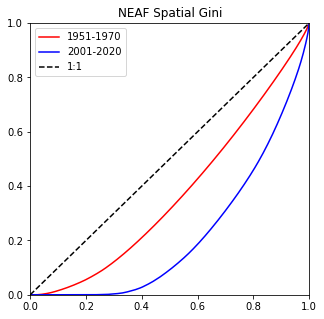

In [36]:

plt.figure(figsize=(5,5))
plt.plot(cumulative_percentage_mean1 ,lorenz_curve_y1_mean1, 'r-', label='1951-1970')
#plt.plot(cumulative_percentage_mean2 ,lorenz_curve_y1_mean2, 'g-', label='1971-1990')
plt.plot(cumulative_percentage_mean3 ,lorenz_curve_y1_mean3, 'b-', label='2001-2020')
#plt.plot(cumulative_percentage, lorenz_curve_y3, 'b-', label='2020')
plt.plot([0, 1], [0, 1], 'k--', label='1:1')

plt.legend()
plt.title('NEAF Spatial Gini')
plt.xlim(0,1)
plt.ylim(0,1)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('ex1a.svg')

# CAF

In [24]:
def calculate_lorenz_curve(data):
    data_sorted = np.sort(data)
    cumulative_percentage = np.arange(1, len(data) + 1) / len(data)
    lorenz_curve_y = np.cumsum(data_sorted) / np.sum(data_sorted)
    return cumulative_percentage, lorenz_curve_y

for region in range(22,23):
    cumulative_percentage_cum=np.zeros((20,384))
    lorenz_curve_y1_cum=np.zeros((20,384))
    for year in range(0,20):
        data_temp=np.array(pd.DataFrame(pre_year_end[year,:,:]*mask_46[region,:,:]).fillna(9999))
        data_flatten=data_temp.flatten(('c'))
        data_flatten.sort()
        data_list=data_flatten[0:int(index_region[region])]
        data1 = data_list
        # 计算每组数据的洛伦兹曲线
        cumulative_percentage, lorenz_curve_y1 = calculate_lorenz_curve(data1)
        cumulative_percentage_cum[year,:]=cumulative_percentage
        lorenz_curve_y1_cum[year,:]=lorenz_curve_y1
    cumulative_percentage_mean1=np.nanmean(cumulative_percentage_cum,axis=0)
    lorenz_curve_y1_mean1=np.nanmean(lorenz_curve_y1_cum,axis=0)



In [25]:
for region in range(22,23):
    cumulative_percentage_cum=np.zeros((20,384))
    lorenz_curve_y1_cum=np.zeros((20,384))
    for year in range(50,70):
        data_temp=np.array(pd.DataFrame(pre_year_end[year,:,:]*mask_46[region,:,:]).fillna(9999))
        data_flatten=data_temp.flatten(('c'))
        data_flatten.sort()
        data_list=data_flatten[0:int(index_region[region])]
        data1 = data_list
        # 计算每组数据的洛伦兹曲线
        cumulative_percentage, lorenz_curve_y1 = calculate_lorenz_curve(data1)
        cumulative_percentage_cum[year-50,:]=cumulative_percentage
        lorenz_curve_y1_cum[year-50,:]=lorenz_curve_y1
    cumulative_percentage_mean3=np.nanmean(cumulative_percentage_cum,axis=0)
    lorenz_curve_y1_mean3=np.nanmean(lorenz_curve_y1_cum,axis=0)
 

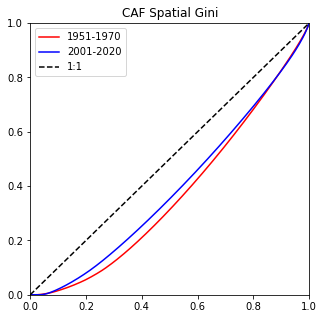

In [33]:
plt.figure(figsize=(5,5))
plt.plot(cumulative_percentage_mean1 ,lorenz_curve_y1_mean1, 'r-', label='1951-1970')
#plt.plot(cumulative_percentage_mean2 ,lorenz_curve_y1_mean2, 'g-', label='1971-1990')
plt.plot(cumulative_percentage_mean3 ,lorenz_curve_y1_mean3, 'b-', label='2001-2020')
#plt.plot(cumulative_percentage, lorenz_curve_y3, 'b-', label='2020')
plt.plot([0, 1], [0, 1], 'k--', label='1:1')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('CAF Spatial Gini')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('ex1b.svg')

In [70]:
pre_50_55

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360, time: 2190)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-02 1950-01-03 ... 1955-12-31
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
Data variables:
    tp         (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Mon Oct 03 10:43:04 2022: cdo samplegrid,10 era5_50-55.nc e...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...